In [1]:
import os
from keras_tft import TFTForecaster, plot_probabilistic_forecast, preprocess_time_series, timeseries_cv_with_covariates
import pandas as pd

In [2]:
FORECAST_HORIZON = 24
INPUT_LEN = FORECAST_HORIZON * 7  # 7 days of history (reduced from 30 due to small dataset) 
EPOCHS = 30 # Number of epochs for training

# Westbound traffic volume on the I-94 between Minneapolis and St-Paul in Minnesota, starting on September 29, 2016, at 5pm
path = 'data/hourly_traffic.csv'

In [ ]:
CUTOFF_DATE = '2016-11-01'
# Preprocess data
# We include Friday in weekend as per original notebook logic (weekday 4,5,6)
# The function now returns history and the full prediction input (history + future)
data, pred_input, test_df, scaler = preprocess_time_series(
    cutoff_date=CUTOFF_DATE,
    file_path=path,
    forecast_horizon=FORECAST_HORIZON,
    is_holiday=True,
    country='US',
    is_weekend=True
)

data.head()

,id_column,timestamp,y,is_holiday,is_weekend
0,0,2016-09-29 17:00:00,0.844240,0,0
1,0,2016-09-29 18:00:00,0.619395,0,0
2,0,2016-09-29 19:00:00,0.508953,0,0
3,0,2016-09-29 20:00:00,0.402789,0,0
4,0,2016-09-29 21:00:00,0.351767,0,0


In [ ]:
# Initialize TFT Forecaster model
model = TFTForecaster(
    input_chunk_length=INPUT_LEN, 
    output_chunk_length=FORECAST_HORIZON, 
    quantiles=[0.1, 0.5, 0.9]
)

In [5]:
# Train the model
model.fit(
    data, 
    target_col="y", 
    future_cov_cols=["is_weekend", "is_holiday"], 
    epochs=20,
    use_early_stopping=True, early_stopping_patience=2
)

Training on 584 samples. Past: 3, Future: 2, Static: 0
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - loss: 0.4032 - learning_rate: 0.0030
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2524 - learning_rate: 0.0030
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2451 - learning_rate: 0.0030
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2406 - learning_rate: 0.0030
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2337 - learning_rate: 0.0030
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2085 - learning_rate: 0.0030
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1618 - learning_rate: 0.0030
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1368 - learning_rate: 0.0030
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1130 - learning_rate: 0.0030
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0943 - learning_rate: 0.0030
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16

In [6]:
# Forecast
forecast = model.predict(pred_input)
forecast

,q10,q50,q90
0,0.705544,0.762521,0.827070
1,0.705006,0.748737,0.806124
2,0.715139,0.757980,0.811268
3,0.728570,0.778132,0.827401
4,0.739344,0.797912,0.848877
5,0.744176,0.816862,0.874424
6,0.756278,0.851452,0.917287
7,0.756397,0.869058,0.940594
8,0.644294,0.755391,0.854541
9,0.497765,0.591550,0.724875


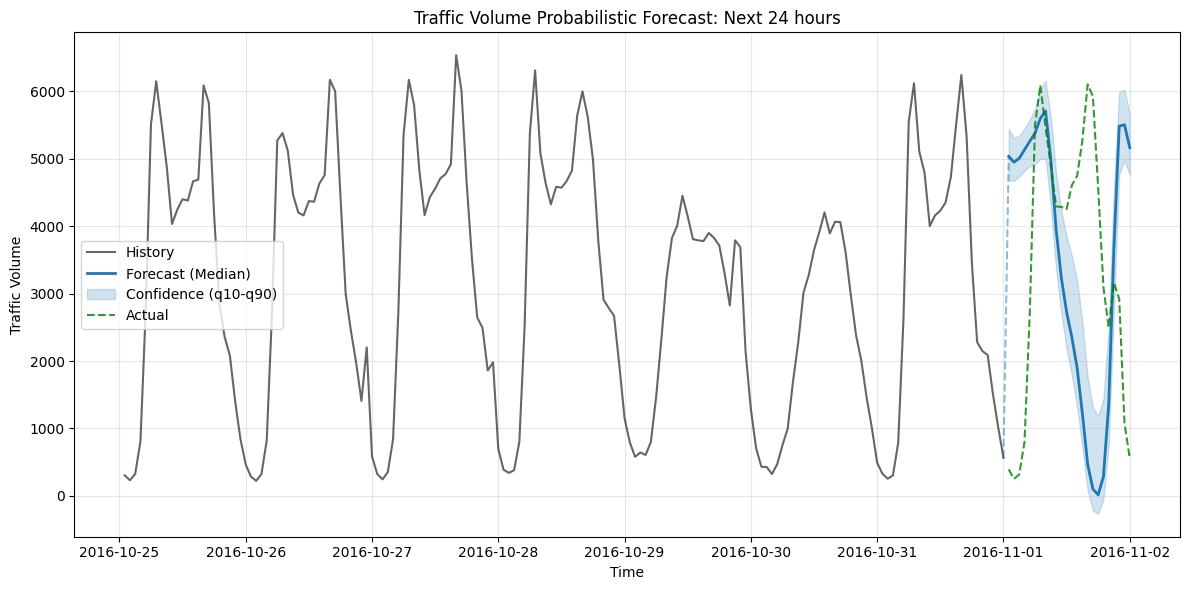

In [7]:
# Plot the probabilistic forecast
plot_probabilistic_forecast(
    history_df=data,
    forecast_df=forecast, 
    target_col="y",
    scaler=scaler, actual_df=test_df,
    timeseries_name="Traffic Volume",
    time_col="timestamp",      
    history_length=INPUT_LEN     
)

In [8]:
results = timeseries_cv_with_covariates(
    model=model,
    df=data,
    num_windows=5,
    forecast_horizon=FORECAST_HORIZON,    
)


CROSS-VALIDATION: 2016-10-27 to 2016-11-01
Forecast Horizon: 24 hours | Windows: 5

Window   1 | Date: 2016-10-27 | Train:  656 hours | RMSE:   0.07 | MAE:   0.05 | MAPE: 35.03%
Window   2 | Date: 2016-10-28 | Train:  680 hours | RMSE:   0.05 | MAE:   0.04 | MAPE: 20.83%
Window   3 | Date: 2016-10-29 | Train:  704 hours | RMSE:   0.10 | MAE:   0.07 | MAPE: 23.28%
Window   4 | Date: 2016-10-30 | Train:  728 hours | RMSE:   0.07 | MAE:   0.06 | MAPE: 36.41%
Window   5 | Date: 2016-10-31 | Train:  752 hours | RMSE:   0.04 | MAE:   0.03 | MAPE: 41.11%

CROSS-VALIDATION SUMMARY
Total Windows: 5
Overall RMSE: 0.07
Overall MAE:  0.05
Overall MAPE: 31.33%

